# 2023-09-20 · STA conntest for diff recording quality n durations 

In [1]:
include("lib/Nto1.jl")

using Revise … ✔ (0.3 s)
using Units, Nto1AdEx, ConnectionTests, ConnTestEval, MemDiskCache … 

[ Info: Precompiling MemDiskCache [40c6d27e-4dd7-460c-8c4c-2ed37df2112f]


✔ (1.9 s)
using StatsBase … ✔ (0.2 s)


In [2]:
N = 6500
duration = 10minutes
@time sim = Nto1AdEx.sim(N, duration);  # ceil_spikes is true by default

  2.959043 seconds (2.10 M allocations: 1.024 GiB, 2.97% gc time, 45.13% compilation time)


## VI noise

In [75]:
(; Vₛ, Eₗ) = Nto1AdEx

function VI_sig(sim; spike_SNR = 10, spike_height = (Vₛ - Eₗ), seed=1)
    Random.seed!(seed)
    σ = spike_height / spike_SNR
    sig = copy(sim.V)
    sig .+= (σ .* randn(length(sig)))
    sig
end;

sig = VI_sig(sim);

In [76]:
include("lib/plot.jl")

import PythonCall … ✔ (2 s)
import PythonPlot … ✔ (3.9 s)
using Sciplotlib … ✔ (0.6 s)
using PhDPlots … ✔


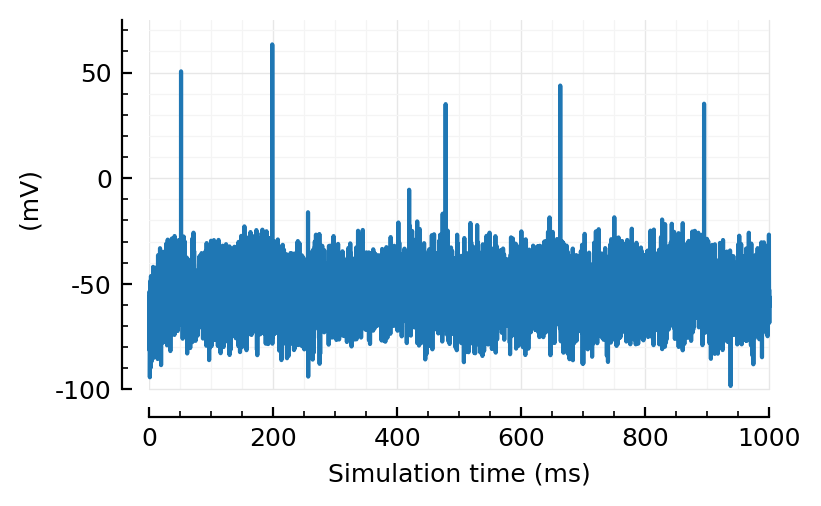

In [77]:
plotsig(sig, [0,1000], ms, yunit=:mV);

Very good.

In [78]:
VI_sig(sim, spike_SNR=Inf) == sim.V

true

Excellent.

## Clip the VI sig

In [82]:
include("lib/df.jl")

using DataFrames … ✔


In [85]:
ps = [95, 98, 99, 99.9, 99.95, 99.99, 100]
qs = percentile(sig, ps)
df = DataFrame("p" => ps, "V (mV)" => qs/mV)

Row,p,V (mV)
,Float64,Float64
1,95,-36.5
2,98,-32.1
3,99,-29.1
4,99.9,-19.1
5,100,-11.2
6,100,48.6
7,100,83.5


For the clean (no VI noise) signal, we clipped at -49.79 mV (which was there the 99 percentile)

If we do same:

In [86]:
clip!(sig, p = 99) = begin
    thr = percentile(sig, p)
    to_clip = sig .≥ thr
    sig[to_clip] .= thr
    sig
end;

In [95]:
sigc = clip!(copy(sig), 99);

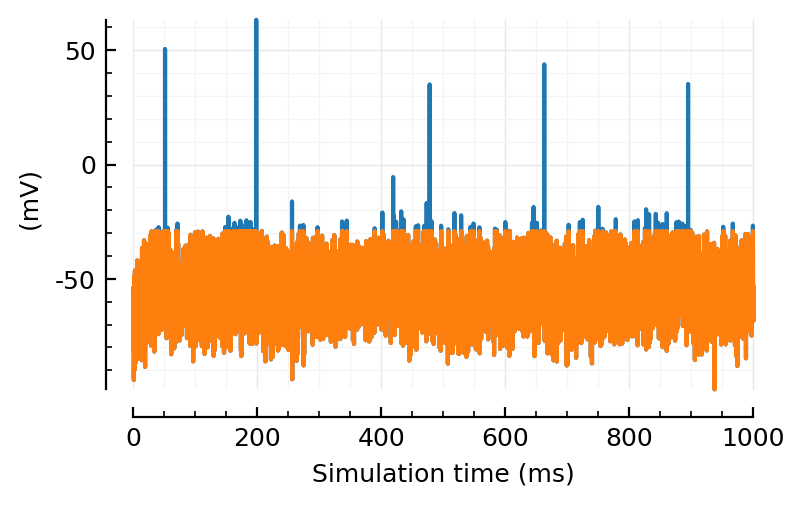

In [98]:
tlim=[0,1000]
plotsig(sig , tlim, ms, yunit=:mV)
plotsig(sigc, tlim, ms, yunit=:mV, yunits_in=nothing);

Hm, we might loose some non-spike signal there?  
So let's choose sth stricter:  (note that this is all for VI SNR 10, no systematic search.. But 10 is a realistic SNR, so, fine).

In [103]:
clip_pctile = 99.9
sigc = clip!(copy(sig), clip_pctile);

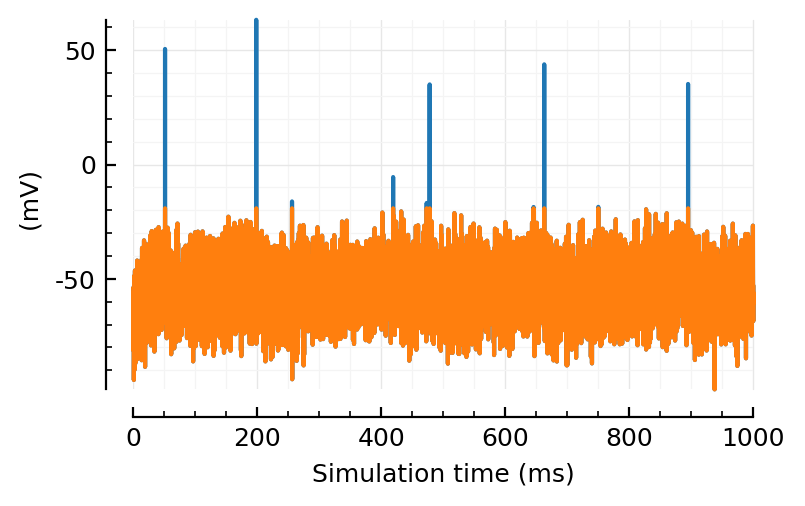

In [104]:
plotsig(sig , tlim, ms, yunit=:mV)
plotsig(sigc, tlim, ms, yunit=:mV, yunits_in=nothing);

## Test conns

In [105]:
cachedir = "2023-09-20__STA_conntest_for_diff_recording_quality_n_durations";

In [106]:
sim_ = CachedFunction(Nto1AdEx.sim, cachedir; disk=false, duration=10minutes, N)

CachedFunction(Nto1AdEx.sim, ThreadSafeDicts.ThreadSafeDict{Any, Any}(), false, true, "C:\\Users\\tfiers\\.julia\\MemDiskCache.jl\\2023-09-20__STA_conntest_for_diff_recording_quality_n_durations\\sim", Symbol[], Base.Pairs{Symbol, Real, Tuple{Symbol, Symbol}, NamedTuple{(:duration, :N), Tuple{Float64, Int64}}}(:duration => 600, :N => 6500))

In [107]:
MemDiskCache.set_dir(cachedir);

In [108]:
# MemDiskCache.open_dir()

In [114]:
function sim_and_test(; duration=10minutes, VI_SNR=Inf)
    sim = sim_(; duration)
    sig = VI_sig(sim, spike_SNR=VI_SNR)
    sigc = clip!(sig, clip_pctile)
    key = "sim_and_test" * string((; duration, VI_SNR)) * "__rows"
    rows = @cached key test_high_firing_inputs(sim, sigc)
    # ↪ every row is a putative connection. (real type, t-val, presyn fr)
    df = DataFrame(rows)
    sweep = sweep_threshold(df)
    return (; sim, sigc, df, sweep)
end

sim_and_test (generic function with 1 method)

In [206]:
rows = []
for VI_SNR in [Inf, 100, 20, 10, 4, 2, 1]
    (; sweep) = sim_and_test(; VI_SNR)
    F1max = maximum(skipnan(sweep.F1))
    (; AUC) = calc_AUROCs(sweep)
    row = (; VI_SNR, F1max, AUC)
    push!(rows, row)
    # println("\n", row, "\n"^2)
end;

[ Info: Loading `sim_and_test(duration = 600, VI_SNR = Inf)__rows` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 100)__rows` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 20)__rows` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 10)__rows` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 4)__rows` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 2)__rows` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 1)__rows` from memory


In [207]:
df = DataFrame(rows)
showsimple(df)

 VI_SNR  F1max  AUC   
──────────────────────
 Inf     0.829  0.796
 100     0.72   0.679
  20     0.524  0.344
  10     0.458  0.277
   4     0.406  0.239
   2     0.398  0.233
   1     0.386  0.225

Without clipping (from a first run, when I forgot to clip; only ceilin):
```
(VI_SNR = Inf, F1max = 0.697)
(VI_SNR = 10,  F1max = 0.469)
(VI_SNR = 4,   F1max = 0.404)
(VI_SNR = 2,   F1max = 0.398)
(VI_SNR = 1,   F1max = 0.390)
```
Note that, except at Inf snr, not much diff !

In [198]:
set_mpl_style!(sciplotlib_style);

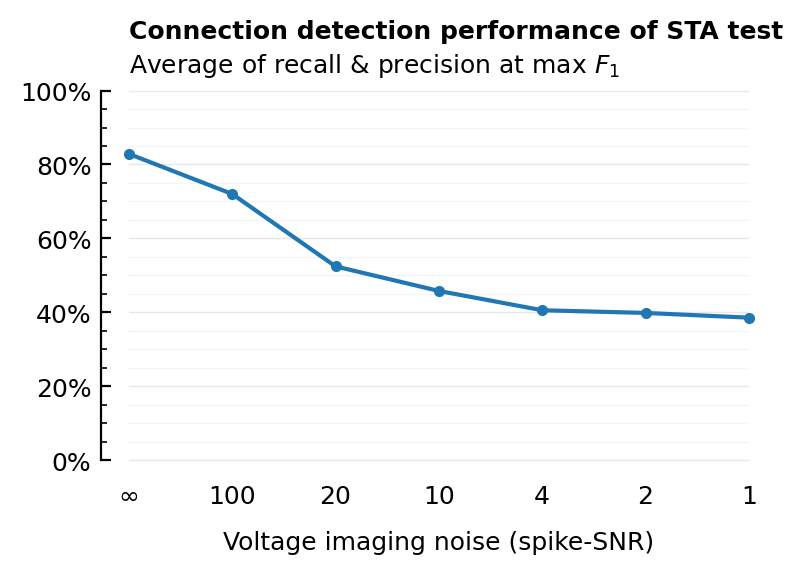

In [205]:
fmt(x) = isinf(x) ? "∞" : round(Int, x);

fig, ax = plt.subplots()
plot(1:nrow(df), df.F1max, ".-"; ax, xticklabels=fmt.(df.VI_SNR), ytype=:fraction, xtype=:categorical,
     xlabel="Voltage imaging noise (spike-SNR)")
t = hylabel(ax, L"Average of recall & precision at $\max\ F_1$");
ax.annotate("Connection detection performance of STA test", fontweight="bold",
            xy=(0, 1.3), xycoords=t, va="bottom");

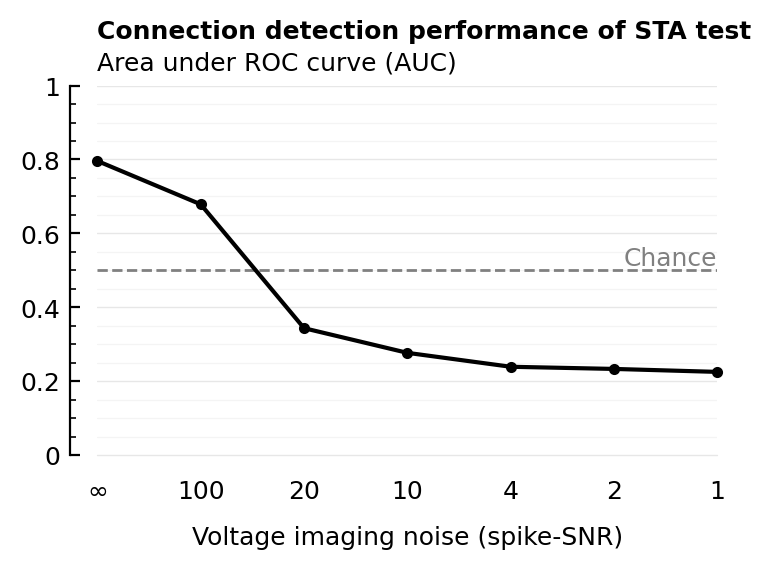

In [243]:
fmt(x) = isinf(x) ? "∞" : round(Int, x);

fig, ax = plt.subplots()
color = "gray"
l = ax.axhline(0.5; lw=1, ls="--", color)
ax.annotate("Chance"; xy=(1,0), xycoords=l, ha="right", va="bottom", color)
plot(1:nrow(df), df.AUC, ".-"; ax, xticklabels=fmt.(df.VI_SNR), ylim=[0,1], xtype=:categorical,
     xlabel="Voltage imaging noise (spike-SNR)", color="black")
t = hylabel(ax, "Area under ROC curve (AUC)");
ax.annotate("Connection detection performance of STA test", fontweight="bold",
            xy=(0, 1.3), xycoords=t, va="bottom");